---
title: "Instrumental variable analysis with a binary outcome"
mathjax: true
toc: true
toc_sticky: true
categories: [data science, statistics]
---

Here is an additional post in instrumental variable (IV) analysis. This follows an exercise where I employed two methods of IV analysis, [comparing a Bayesian approach with two-stage least squares (2SLS)](https://benslack19.github.io/data%20science/statistics/iv-pymc-sm/). My motivation for these posts is to to have a better understanding, ultimately, of Mendelian randomization. The context in which I ultimately want to apply it to is a disease outcome, which is binary. In this post, I explore what modifications we would need to make to apply IV analysis to a binary outcome with simulated data.

*Note: Some of the coding implementation was tricky for me initially. Thanks to [the man](https://xcelab.net/rm/) himself for providing some [help](https://x.com/rlmcelreath/status/1798972577387339782).*

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import scipy.stats as stats
import seaborn as sns
from scipy.special import expit
from utils import draw_causal_graph, standardize

In [2]:
RANDOM_SEED = 73
np.random.seed(RANDOM_SEED)
sns.set_context("talk")
sns.set_palette("colorblind")
cb_palette = sns.color_palette()

Notes
- check p per subject
- model, binary outcome, variable n

# Causal graph of example dataset with binary outcome

We'll return to the wages and education example from Chapter 14 of Statistical Rethinking. However, instead of using wages as our outcome, we'll tweak this by creating a binary outcome from wages, which I'll refer to as $R$ for "rich". The causal diagram will look the same as a traditional IV setup.

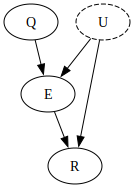

In [3]:
draw_causal_graph(
    edge_list=[("Q", "E"), ("U", "E"), ("U", "R"), ("E", "R")],
    node_props={"U": {"style": "dashed"}},
    graph_direction="TD",
)

Per usual, we'll use this to generate a simulated dataset. We'll use the same code but this time derive `R` from `W`. The rationale being those with higher wages are more likely to be rich. We’ll still making the influence of education on wages (`bEW_sim`) equal to 0. We'll want to get this value back in our statistical models, even though we'll be using `R` as our ultimate outcome variable.

A key conceptual point is use of a logit link function to produce `R` from `W`.  Additionally, we'll make use of a [binomial generalized linear model](https://benslack19.github.io/data%20science/statistics/multilevel_modeling_01/). Another tricky thing working with count data is that we need a certain number of "observations" per person.

In [52]:
def generate_data(num_subjects, n_binomial_param) -> pd.DataFrame:
    """Generate simulated data.

    Parameters
    ----------
    num_subjects
        Number of subjects/rows in data
    n_binomial_param
        Number of "observations" for each subject;
        a parameter in the binomial GLM

    Returns
    -------
    sim_df
        pd.DataFrame

    """

    bEW_sim = 0

    U_sim = np.random.normal(size=num_subjects)
    Q_sim = np.random.randint(1, 5, size=num_subjects)
    E_sim = np.random.normal(loc=U_sim + Q_sim, size=num_subjects)
    W_sim = np.random.normal(loc=U_sim + bEW_sim * E_sim, size=num_subjects)
    sim_df = pd.DataFrame.from_dict(
        {"W": standardize(W_sim), "E": standardize(E_sim), "Q": standardize(Q_sim)}
    )

    # Use of link functions to generate R
    index_val = sim_df.index.values
    sim_df["R"] = stats.binom.rvs(n=n_binomial_param, p=expit(W_sim))
    sim_df["R_size"] = n_binomial_param

    return sim_df


dat_sim = generate_data(num_subjects=500, n_binomial_param=2)
dat_sim.head()

,W,E,Q,R,R_size
0,-1.327032,-0.600469,0.453638,1,2
1,-0.108554,-0.159673,-1.318387,0,2
2,-0.908108,1.066808,0.453638,2,2
3,-2.187143,-2.856829,-1.318387,0,2
4,0.044873,-0.024763,-0.432374,1,2


As usual, visualizing the data can give us some insight into how the data *appears* and where confounds may mislead. We know that `Q` is a cause of `E` and therefore the associatoin we see is reflective of causation. The bottom-left figure `W` vs. `R` is a logit transformation of the former into the latter. However, both the plots in the right column are a result of the confound `U`. It is driving the relationship between `E` and `W` and therefore we also see an association between `E` and `R`.

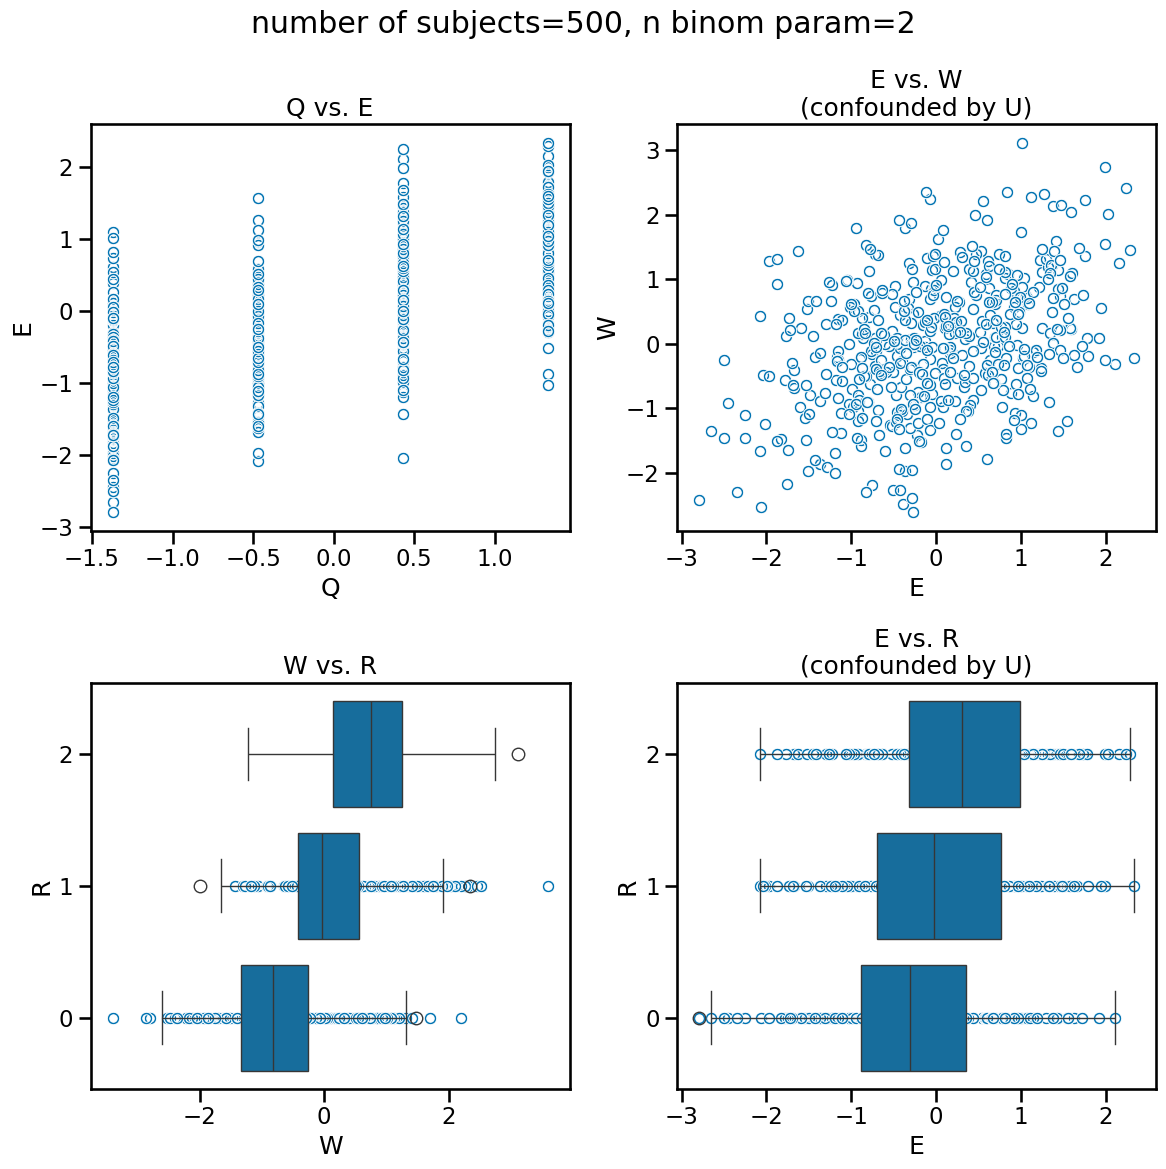

In [43]:
def plot_variable_relationships(sim_df, title):
    f, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(12, 12))

    sns.scatterplot(data=sim_df, x="Q", y="E", marker=r"$\circ$", ax=ax0)
    ax0.set_title("Q vs. E")

    sns.scatterplot(data=sim_df, x="E", y="W", marker=r"$\circ$", ax=ax1)
    ax1.set_title("E vs. W\n(confounded by U)")

    sns.boxplot(data=sim_df, x="W", y="R", orient="h", color=cb_palette[0], ax=ax2)
    sns.scatterplot(data=dat_sim_n1, x="W", y="R", marker=r"$\circ$", ax=ax2)
    ax2.invert_yaxis()
    ax2.set_title("W vs. R")

    sns.boxplot(data=sim_df, x="E", y="R", orient="h", color=cb_palette[0], ax=ax3)
    sns.scatterplot(data=sim_df, x="E", y="R", marker=r"$\circ$", ax=ax3)
    ax3.invert_yaxis()
    ax3.set_title("E vs. R\n(confounded by U)")

    f.suptitle(title)
    f.tight_layout()


plot_variable_relationships(dat_sim, "number of subjects=500, n binom param=2")

# Bayesian model with binary outcome

We'll use the Bayesian approach to run our inferential model. Again, the important thing is the link function to get our count output.

$$ R_i \sim \text{Binomial}(n_i, p_i) $$
$$ \text{logit}(p_i) = W_i $$
$$ \left( \begin{array}{c} W_i \\ {E_i} \end{array} \right) \sim \text{MVNormal} \left( \begin{array}{c}{\mu_{W_i}}  \\ {\mu_{E_i} } \end{array} , \textbf{S} \right)    $$

$$ \mu_{W_i} = \alpha_W + \beta_{EW} W_i  $$
$$ \mu_{E_i} = \alpha_E + \beta_{QE} E_i  $$
$$ \alpha_W, \alpha_E \sim \text{Normal}(0, 0.2) $$
$$ \beta_{EW}, \beta_{QE} \sim \text{Normal}(0, 1.5) $$

$$
\textbf{S} = \begin{pmatrix} \sigma_{W}^2 & \rho\sigma_{W}\sigma_{E} \\ 
                \rho\sigma_{W}\sigma_{E} & \sigma_{E}^2 \end{pmatrix} = \begin{pmatrix} \sigma_{P} & 0 \\ 0 & \sigma_{\beta} \end{pmatrix} \textbf{R} \begin{pmatrix} \sigma_{W} & 0 \\ 0 & \sigma_{E} \end{pmatrix}
$$

$$
\textbf{R} \sim \text{LKJCorr}(2)
$$

In [18]:
def run_bayesian_iv_model_binary(data_df):
    """Model for education/rich binary outcome.

    Parameters
    ----------
    data_df
        Generated dataset

    Returns
    -------
    :
        pymc idata object
    """

    index_vals = data_df.index.values

    with pm.Model() as model:
        aW = pm.Normal("aW", 0.0, 0.2)
        aE = pm.Normal("aE", 0.0, 0.2)
        bEW = pm.Normal("bEW", 0.0, 0.5)
        bQE = pm.Normal("bQE", 0.0, 0.5)

        muW = pm.Deterministic("muW", aW + bEW * data_df.E.values)
        muE = pm.Deterministic("muE", aE + bQE * data_df.Q.values)

        chol, _, _ = pm.LKJCholeskyCov(
            "chol_cov", n=2, eta=2, sd_dist=pm.Exponential.dist(1.0), compute_corr=True
        )

        # multivariate regression
        MU = pt.stack([muW, muE]).T
        YY_obs = pm.Data("YY_obs", data_df[["R", "E"]].values)
        YY = pm.MvNormal("YY", mu=MU, chol=chol, observed=YY_obs)

        # link function
        p = pm.Deterministic("p", pm.math.invlogit(YY[index_vals, 0]))
        R = pm.Binomial("R", n=data_df["R_size"], p=p, observed=data_df["R"])

        idata = pm.sample(1000, random_seed=RANDOM_SEED, target_accept=0.95)
        idata.rename({"chol_cov_corr": "Rho", "chol_cov_stds": "Sigma"}, inplace=True)

    return idata

In [13]:
idata_14_6_logit = run_bayesian_iv_model_binary(dat_sim)

Sampling 4 chains, 0 divergences ━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━  32% 0:00:17 / 0:00:10

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.


Text(0.5, 1.0, 'm14.6 with logistic link')

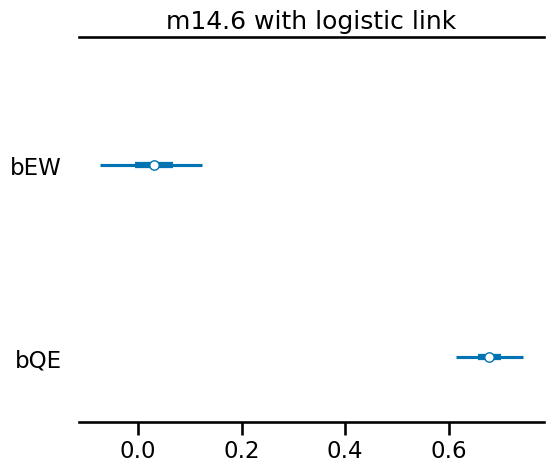

In [14]:
f, ax0 = plt.subplots(1, 1, figsize=(6, 5), sharex=True)
az.plot_forest(idata_14_6_logit, var_names=["bEW", "bQE"], combined=True, ax=ax0)
ax0.set_title("m14.6 with logistic link")

As you can see, we get coefficients as the original [wages and education example](https://benslack19.github.io/data%20science/statistics/iv-pymc-sm/#comparison-of-estimates-between-approaches).

# Experimenting with number of subjects and the binomial parameter

In [24]:
dat_sim_nsubj500_n1 = generate_data(num_subjects=500, n_binomial_param=1)
dat_sim_nsubj500_n1.head()

,W,E,Q,R,R_size
0,-1.187452,0.117892,0.429942,0,1
1,-0.213500,-0.020150,1.356542,1,1
2,0.988813,0.609921,-0.496658,1,1
3,-0.795627,0.179087,1.356542,0,1
4,-0.941324,-0.101168,0.429942,0,1


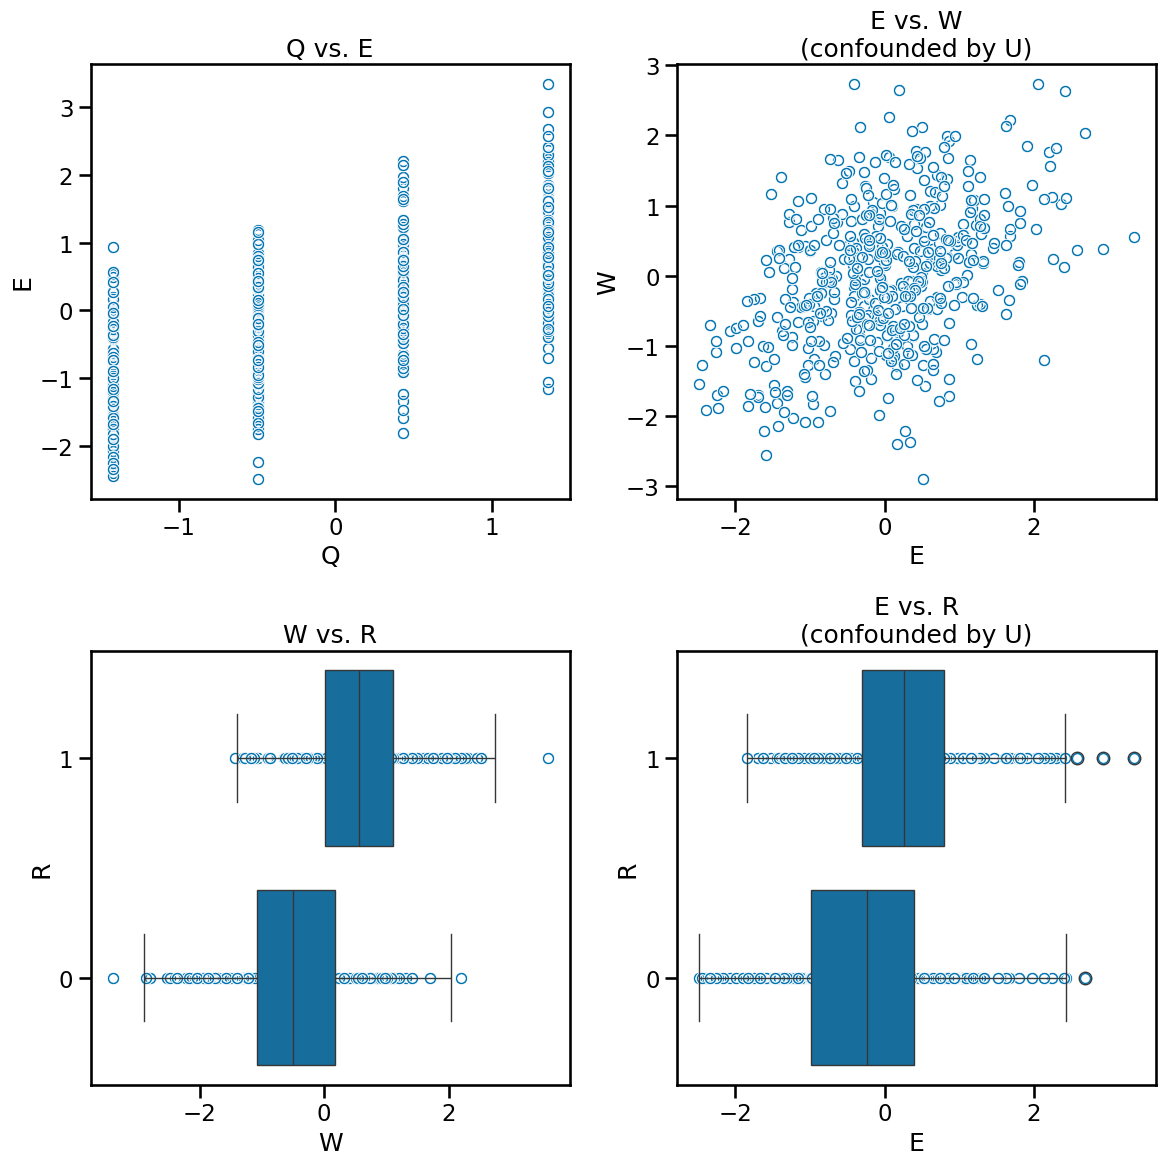

In [39]:
plot_variable_relationships(dat_sim_nsubj500_n1)

Play with parameters

In [56]:
num_subjects_list = [25, 100, 200, 500]
n_binomial_param_list = [1, 2, 5]

In [57]:
def format_summary_table(
    idata, num_subjects, n_binomial_param, var_names=["bEW", "bQE"]
):
    df = (
        az.summary(idata, var_names=var_names)
        .assign(num_subjects=num_subjects)
        .assign(n_binomial_param=n_binomial_param)
    )
    return df

In [ ]:
df_summary = list()
for num_subjects in num_subjects_list[0:2]:
    for n_binomial_param in n_binomial_param_list[0:1]:
        dat_sim_expt = generate_data(num_subjects=num_subjects, n_binomial_param=n_binomial_param)
        idata_14_6_logit_expt = run_bayesian_iv_model_binary(dat_sim_expt)
        df_expt_summary = format_summary_table(idata_14_6_logit_expt, num_subjects=num_subjects, n_binomial_param=n_binomial_param)
        df_summary.append(df_summary)

df_summary = pd.concat(df_summary)
df_summary

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [aW, aE, bEW, bQE, chol_cov]


# Comparison of generated data parameters

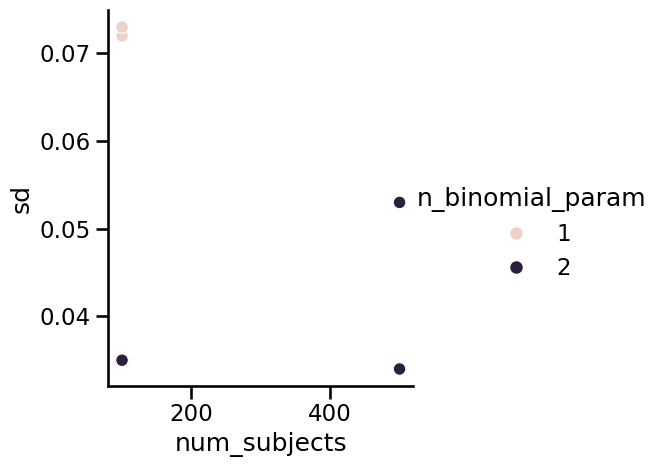

In [50]:
sns.relplot(
    df_summary,
    x='num_subjects',
    y='sd',
    hue='n_binomial_param'
)

# Check with statsmodels

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)

# Number of samples
n = 1000

# Simulate genotype SNP (0, 1, 2) assuming Hardy-Weinberg equilibrium

genotype = np.random.choice([0, 1, 2], size=n, p=[0.25, 0.5, 0.25])
# Simulate protein intensity affected by genotype
# Assume beta_genotype is the effect size of genotype on protein intensity
beta_genotype = 0.5
protein_intensity = beta_genotype * genotype + np.random.normal(size=n)

# Simulate disease outcome affected by protein intensity
# Assume beta_protein is the effect size of protein intensity on disease
beta_protein = 1.0
disease = beta_protein * protein_intensity + np.random.normal(size=n)

# Create a DataFrame
data = pd.DataFrame(
    {"genotype": genotype, "protein_intensity": protein_intensity, "disease": disease}
)

data.head()

In [ ]:
import statsmodels.api as sm
from statsmodels.sandbox.regression.gmm import IV2SLS

# First stage: Regress protein intensity on genotype
first_stage = sm.OLS(data["protein_intensity"], sm.add_constant(data["genotype"])).fit()

# Predicted protein intensity
data["protein_intensity_hat"] = first_stage.predict(sm.add_constant(data["genotype"]))

# Second stage: Regress disease on predicted protein intensity (instrumented)
second_stage = sm.OLS(
    data["disease"], sm.add_constant(data["protein_intensity_hat"])
).fit()

# Summary of the second stage regression
second_stage.summary()

# Check that coefficient using binomial GLM can be recovered from simulated data

In [ ]:
n = 200
a = np.random.normal(size=n)  # intercept at 0
bD = np.random.normal(
    loc=1, scale=0.2, size=n
)  # bD coefficient at 1, make the spread narrow
X = np.random.normal(size=n)  # predictor variable
mu = a + bD * X
D_logit = stats.bernoulli.rvs(p=expit(mu))
df_data_sim_logit = pd.DataFrame({"X": X, "mu": mu, "D": D_logit})

In [ ]:
df_data_sim_logit.head()

In [ ]:
sns.scatterplot(data=df_data_sim_logit, x="X", y="mu", hue="D")

$$ D_i \sim \text{Bernoulli}(p_i) $$
$$ \text{logit}(p_i) = \mu_i $$
$$ \mu_i = \alpha + \beta X_i $$
$$ \alpha \sim \text{Normal}(0,1.5) $$
$$ \beta \sim \text{Normal}(0,1.5) $$

In [ ]:
with pm.Model() as m_logit:

    # priors
    a = pm.Normal("a", mu=0, sigma=2)
    b = pm.Normal("b", mu=0, sigma=2)

    mu = a + b * df_data_sim_logit["X"]

    # link function
    p = pm.math.invlogit(mu)

    d = pm.Bernoulli("d", p=p, observed=df_data_sim_logit["D"])

    trace_m_logit = pm.sample(1000, target_accept=0.9)

In [ ]:
az.summary(trace_m_logit)

In [45]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu Jun 06 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.24.0

seaborn   : 0.13.2
scipy     : 1.13.0
numpy     : 1.26.4
pytensor  : 2.20.0
arviz     : 0.18.0
pandas    : 2.2.2
matplotlib: 3.8.4
pymc      : 5.15.0

Watermark: 2.4.3

